In [ ]:
import os
import json
import glob
import re
import sys
from typing import Dict, List

import torch
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
#import chart_studio
#from chart_studio import plotly as py

from IPython.display import display, clear_output, HTML

sys.path.append("..")
from utils.data_processing import (
    load_edge_scores_into_dictionary,
    compute_weighted_jaccard_similarity,
    compute_weighted_jaccard_similarity_to_reference,
    compute_ewma_weighted_jaccard_similarity,
    generate_in_circuit_df_files,
    load_node_dictionary
)

: 

## Plot Edges

In [2]:
from typing import List, Optional, Tuple, Union

import torch
from torch import Tensor
import numpy as np
import pandas as pd
import yaml
from typing import Tuple, List, Dict

In [3]:
def generate_results_edge(model, TASK, start_checkpoint):
    list_of_df = {}
    for m in model:
        try:
            if TASK == 'ioi':
                in_circuit_df = pd.read_feather(f'/mnt/hdd-0/circuits-over-time/results/graphs/{m}/{TASK}/in_circuit_edges.feather')
            else:
                in_circuit_df = pd.read_feather(f'/mnt/hdd-0/circuits-over-time/results/graphs/{m}/{TASK}/in_circuit_edges_faithful.feather')
            edge_count_df = in_circuit_df.groupby('checkpoint').size().reset_index(name='num_edges')  
            in_circuit_df = edge_count_df[edge_count_df['checkpoint'] >= start_checkpoint]
            list_of_df[m] = edge_count_df
        except:
            continue
    return list_of_df

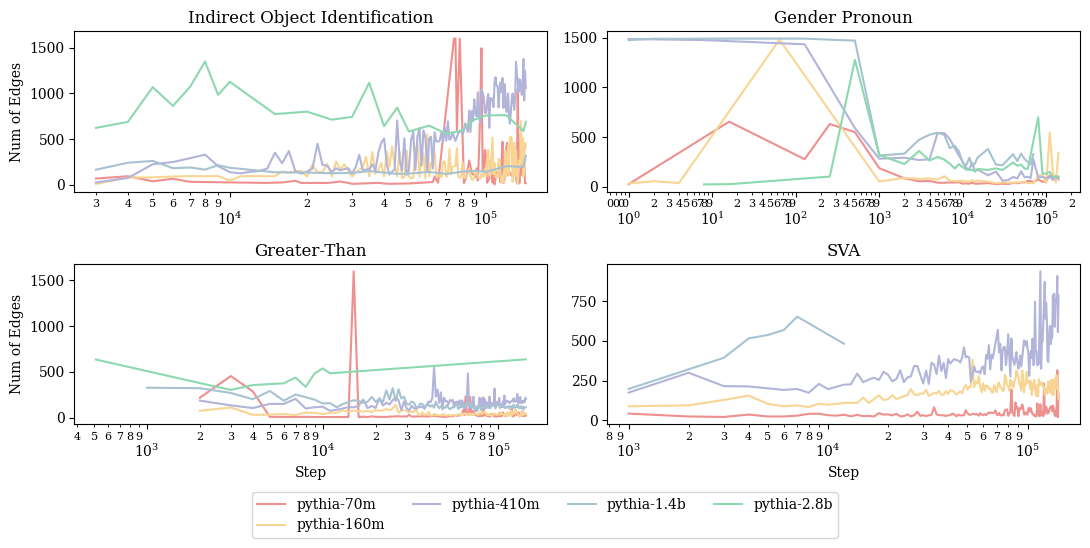

In [6]:
import torch
from pathlib import Path 
import json 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

color_palette = {
  "pythia-70m": "#EE908D",
  "pythia-160m": "#F8D592",
  #"pythia-1b": "#8CD9AF",
  "pythia-410m": "#B2B4D9",
  #"pythia-12b": "#B46F90",
  "pythia-1.4b": "#A7C2D0",
  #"pythia-6.9b": "#BF8271",
  "pythia-2.8b": "#8CD9AF"
}

core_models = list(color_palette.keys())

plt.rcParams["font.family"] = 'DejaVu Serif'

fig, axs = plt.subplots(2,2)
fig.set_size_inches(11, 5)
baselines = generate_results_edge(core_models, 'ioi', 1000)
for k, baseline in baselines.items():
    axs[0,0].plot(baseline['checkpoint'], baseline['num_edges'], label=k, c=color_palette[k])

axs[0,0].set_title('Indirect Object Identification')
axs[0,0].set_ylabel('Num of Edges')

baselines = generate_results_edge(core_models, 'gender_pronoun', 1000)
for k, baseline in baselines.items():
    axs[0,1].plot(baseline['checkpoint'], baseline['num_edges'], label=k, c=color_palette[k])

axs[0,1].set_title('Gender Pronoun')

baselines = generate_results_edge(core_models, 'greater_than', 1000)
for k, baseline in baselines.items():
    axs[1,0].plot(baseline['checkpoint'], baseline['num_edges'], label=k, c=color_palette[k])

axs[1,0].set_title('Greater-Than')
axs[1,0].set_ylabel('Num of Edges')
axs[1,0].set_xlabel('Step')

baselines = generate_results_edge(core_models, 'sva', 1000)
for k, baseline in baselines.items():
    axs[1,1].plot(baseline['checkpoint'], baseline['num_edges'], label=k, c=color_palette[k])
axs[1,1].set_title('SVA')
axs[1,1].set_xlabel('Step')


def first_digit(x, pos):
    return str(x)[0]

for ax in axs.flat:
    ax.set_xscale('log')
    ax.xaxis.set_tick_params(which='minor', labelsize=8)
    ax.xaxis.set_minor_formatter(FuncFormatter(first_digit))
    ax.xaxis.set_tick_params(which='major', pad=10)

handles, labels = axs[1,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=4)
fig.show()
fig.tight_layout()

# Plot Nodes

In [23]:
def generate_in_circuit_df_files(
        graphs_folder: str,
        task: str,
        start_checkpoint: int = 1, 
        limit_to_model: Optional[str] = None, 
        limit_to_task: Optional[str] = None
    ) -> None:
        for model_folder in os.listdir(graphs_folder):
                model_folder_path = os.path.join(graphs_folder, model_folder)
                if os.path.isdir(model_folder_path):  # Check if it's a directory
                        for task_folder in os.listdir(model_folder_path):
                                task_folder_path = os.path.join(model_folder_path, task_folder)
                                if task == "gender_pronoun":
                                        task_folder_path = os.path.join(task_folder_path, 'faithful')
                                # append the subfolder raw to the path
                                task_folder_path = os.path.join(task_folder_path, 'raw')
                                if os.path.isdir(task_folder_path): 
                                        if limit_to_model is not None and model_folder != limit_to_model:
                                                continue
                                        if limit_to_task is not None and task_folder != limit_to_task:
                                                continue
                                        if task == "gender_pronoun":
                                                folder_path = f'{graphs_folder}/{model_folder}/{task_folder}/faithful/raw'
                                        else:
                                                folder_path = f'{graphs_folder}/{model_folder}/{task_folder}/raw'
                                        
                                        return load_node_dictionary(folder_path)
                
        

In [28]:
def generate_results_nodes(model, TASK, start_checkpoint):
    list_of_df = {}
    for m in model:
        in_circuit_df = generate_in_circuit_df_files('/mnt/hdd-0/circuits-over-time/results/graphs', task = TASK, start_checkpoint=1, limit_to_model=m, limit_to_task=TASK)
        if in_circuit_df is not None:
            in_circuit_df = in_circuit_df[in_circuit_df['checkpoint'] >= start_checkpoint]
            list_of_df[m] = in_circuit_df  
    return list_of_df

/mnt/hdd-0/circuits-over-time/results/graphs/pythia-70m/ioi/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-160m/ioi/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-410m/ioi/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-1.4b/ioi/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-2.8b/ioi/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-70m/gender_pronoun/faithful/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-160m/gender_pronoun/faithful/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-410m/gender_pronoun/faithful/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-1.4b/gender_pronoun/faithful/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-2.8b/gender_pronoun/faithful/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-70m/greater_than/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-160m/greater_than/raw
/mnt/hdd-0/circuits-over-time/results/graphs/pythia-410m/greater_than/raw
/mnt/hdd-0/circuits-over-time/r

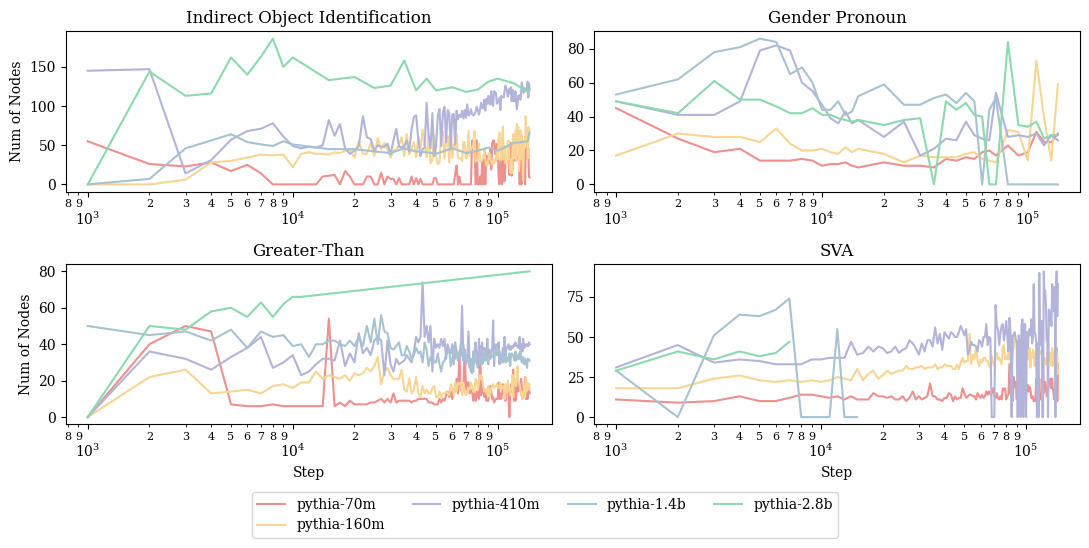

In [33]:
import torch
from pathlib import Path 
import json 
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

color_palette = {
  "pythia-70m": "#EE908D",
  "pythia-160m": "#F8D592",
  #"pythia-1b": "#8CD9AF",
  "pythia-410m": "#B2B4D9",
  #"pythia-12b": "#B46F90",
  "pythia-1.4b": "#A7C2D0",
  #"pythia-6.9b": "#BF8271",
  "pythia-2.8b": "#8CD9AF"
}

core_models = list(color_palette.keys())

plt.rcParams["font.family"] = 'DejaVu Serif'

fig, axs = plt.subplots(2,2)
fig.set_size_inches(11, 5)
baselines = generate_results_nodes(core_models, 'ioi', 1000)
for k, baseline in baselines.items():
    axs[0,0].plot(baseline['checkpoint'], baseline['num_nodes'], label=k, c=color_palette[k])

axs[0,0].set_title('Indirect Object Identification')
axs[0,0].set_ylabel('Num of Nodes')

baselines = generate_results_nodes(core_models, 'gender_pronoun', 1000)
for k, baseline in baselines.items():
    axs[0,1].plot(baseline['checkpoint'], baseline['num_nodes'], label=k, c=color_palette[k])

axs[0,1].set_title('Gender Pronoun')

baselines = generate_results_nodes(core_models, 'greater_than', 1000)
for k, baseline in baselines.items():
    axs[1,0].plot(baseline['checkpoint'], baseline['num_nodes'], label=k, c=color_palette[k])

axs[1,0].set_title('Greater-Than')
axs[1,0].set_ylabel('Num of Nodes')
axs[1,0].set_xlabel('Step')

baselines = generate_results_nodes(core_models, 'sva', 1000)
for k, baseline in baselines.items():
    axs[1,1].plot(baseline['checkpoint'], baseline['num_nodes'], label=k, c=color_palette[k])
axs[1,1].set_title('SVA')
axs[1,1].set_xlabel('Step')


def first_digit(x, pos):
    return str(x)[0]

for ax in axs.flat:
    ax.set_xscale('log')
    ax.xaxis.set_tick_params(which='minor', labelsize=8)
    ax.xaxis.set_minor_formatter(FuncFormatter(first_digit))
    ax.xaxis.set_tick_params(which='major', pad=10)

handles, labels = axs[1,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.02), ncol=4)
fig.show()
fig.tight_layout()